## Using Machine Learning to Predict Social Mobility
Project is based off “Using Big Data Solve Economic and Social Problems,” taught by Raj Chetty and Greg Bruich at Harvard University.

**Goal:** In this Empirical Project, I use variables from Google DataCommons to predict
intergenerational mobility using machine learning methods. The measure of intergenerational
mobility that I focus on is the mean rank of a child whose parents were at the 25th percentile
of the national income distribution in each county (kfr_pooled_p25). The goal is to
construct the best predictions of this outcome using variables, an important step in creating
forecasts of upward mobility that could be used for future generations before data on their
outcomes become available.

**Description of the data:** The data consist of all 2,518 counties with at least 10,000 residents available from the Opportunity Atlas. For **Data Dictionary** please see end of notebook. For more details on the construction of the variables included in this data set, please see [Chetty, Raj, John Friedman, Nathaniel Hendren, Maggie R.Jones, and Sonya R. Porter. 2018. “The Opportunity Atlas: Mapping the Childhood Roots of Social Mobility.” NBER Working Paper No. 25147. ](https://opportunityinsights.org/wp-content/uploads/2018/10/atlas_paper.pdf)

In [1]:
import os
import json
import time
import pickle
import requests

import numpy as np
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import yellowbrick as yb

In [3]:
training = pd.io.stata.read_stata('atlas_training.dta')
training.to_csv('atlas_training.csv')

In [4]:
testing = pd.io.stata.read_stata('atlas_test.dta')
testing.to_csv('atlas_test.csv')

In [5]:
df_train = pd.read_csv("atlas_training.csv", sep=',', header=0)

In [6]:
df_test = pd.read_csv("atlas_test.csv", sep=',', header=0)

In [7]:
df_train.shape

(2518, 129)

In [8]:
df_test.shape

(2518, 3)

In [9]:
#merging train and test together in one dataframe
sm_data = pd.merge(df_train, df_test, on='geoid')
sm_data.head()

,Unnamed: 0_x,geoid,place,pop,housing,kfr_pooled_p25,test,training,P_1,P_2,...,P_114,P_115,P_116,P_117,P_118,P_119,P_120,P_121,Unnamed: 0_y,kfr_actual
0,0,1003.0,Baldwin County,187114,104061,0.388847,0.0,1.0,82.847946,98.593450,...,0.00,2.01,0.00,3.52,0.0,0.00,0.0,0.0,0,0.388847
1,1,1005.0,Barbour County,27321,11829,0.349386,0.0,1.0,76.313896,93.878720,...,0.00,4.84,0.00,1.61,0.0,3.23,0.0,0.0,1,0.349386
2,2,1007.0,Bibb County,22754,8981,0.363391,0.0,1.0,73.765620,104.868470,...,0.00,7.27,0.00,1.82,0.0,0.00,0.0,0.0,2,0.363391
3,3,1013.0,Butler County,20624,9964,0.357249,0.0,1.0,92.096670,121.073296,...,0.00,5.36,0.00,1.79,0.0,0.00,0.0,0.0,3,0.357249
4,4,1015.0,Calhoun County,117714,53289,0.361847,0.0,1.0,76.938210,95.478250,...,0.61,3.03,0.61,2.42,0.0,0.00,0.0,0.0,4,0.361847


In [10]:
sm_data.shape

(2518, 131)

In [15]:
list(sm_data.columns.values) 

['Unnamed: 0_x',
 'geoid',
 'place',
 'pop',
 'housing',
 'kfr_pooled_p25',
 'test',
 'training',
 'P_1',
 'P_2',
 'P_3',
 'P_4',
 'P_5',
 'P_6',
 'P_7',
 'P_8',
 'P_9',
 'P_10',
 'P_11',
 'P_12',
 'P_13',
 'P_14',
 'P_15',
 'P_16',
 'P_17',
 'P_18',
 'P_19',
 'P_20',
 'P_21',
 'P_22',
 'P_23',
 'P_24',
 'P_25',
 'P_26',
 'P_27',
 'P_28',
 'P_29',
 'P_30',
 'P_31',
 'P_32',
 'P_33',
 'P_34',
 'P_35',
 'P_36',
 'P_37',
 'P_38',
 'P_39',
 'P_40',
 'P_41',
 'P_42',
 'P_43',
 'P_44',
 'P_45',
 'P_46',
 'P_47',
 'P_48',
 'P_49',
 'P_50',
 'P_51',
 'P_52',
 'P_53',
 'P_54',
 'P_55',
 'P_56',
 'P_57',
 'P_58',
 'P_59',
 'P_60',
 'P_61',
 'P_62',
 'P_63',
 'P_64',
 'P_65',
 'P_66',
 'P_67',
 'P_68',
 'P_69',
 'P_70',
 'P_71',
 'P_72',
 'P_73',
 'P_74',
 'P_75',
 'P_76',
 'P_77',
 'P_78',
 'P_79',
 'P_80',
 'P_81',
 'P_82',
 'P_83',
 'P_84',
 'P_85',
 'P_86',
 'P_87',
 'P_88',
 'P_89',
 'P_90',
 'P_91',
 'P_92',
 'P_93',
 'P_94',
 'P_95',
 'P_96',
 'P_97',
 'P_98',
 'P_99',
 'P_100',
 'P_101',


In [16]:
#Labeling our X and y data
X = sm_data[['geoid','pop','housing','P_1','P_2','P_3','P_4','P_5','P_6','P_7',
             'P_8','P_9','P_10','P_11','P_12','P_13','P_14','P_15','P_16','P_17','P_18',
             'P_19','P_20','P_21','P_22','P_23','P_24','P_25','P_26','P_27','P_28','P_29',
             'P_30','P_31','P_32','P_33','P_34','P_35','P_36','P_37','P_38','P_39','P_40',
             'P_41','P_42','P_43','P_44','P_45','P_46','P_47','P_48','P_49','P_50','P_51',
             'P_52','P_53','P_54', 'P_55','P_56','P_57','P_58','P_59','P_60','P_61','P_62',
             'P_63','P_64','P_65','P_66','P_67','P_68','P_69','P_70','P_71','P_72','P_73',
             'P_74', 'P_75','P_76','P_77','P_78','P_79','P_80','P_81','P_82','P_83','P_84',
             'P_85','P_86','P_87','P_88','P_89','P_90','P_91','P_92','P_93','P_94','P_95',
             'P_96','P_97','P_98','P_99','P_100','P_101','P_102','P_103','P_104','P_105',
             'P_106','P_107','P_108','P_109','P_110','P_111','P_112','P_113','P_114','P_115',
             'P_116', 'P_117', 'P_118','P_119','P_120','P_121']]

y = sm_data[['kfr_actual']]

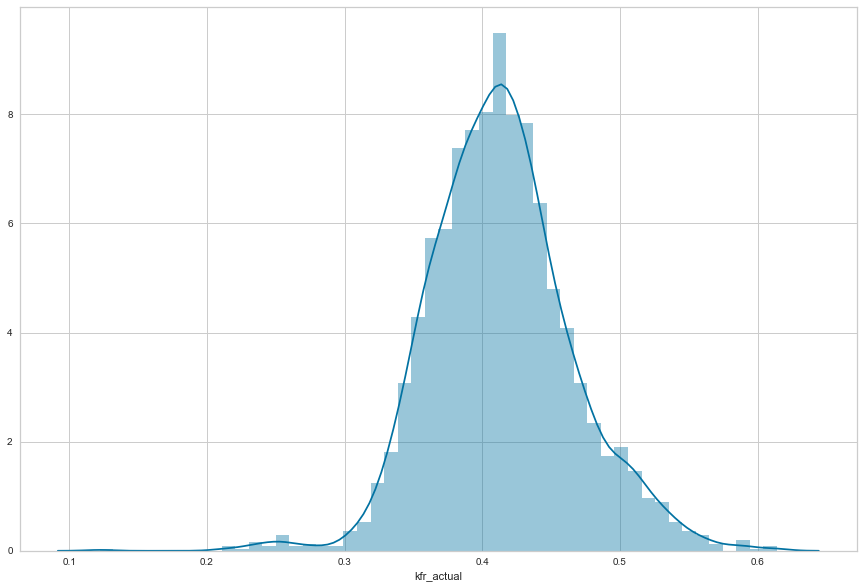

In [17]:
#plotting distribution of our target variable 
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.distplot(sm_data['kfr_actual'])

In [18]:
#Splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
training = pd.io.stata.read_stata('atlas_training.dta')
training.to_csv('atlas_training.csv')

## Multivariable Linear Regression##

In [19]:
#Now let's train and fit our model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
#To retrieve the intercept:
print(regressor.intercept_)

print(regressor.coef_)

[-4.53]
[[0.00 0.00 -0.00 -0.00 -0.00 0.00 0.00 -0.00 0.00 0.00 -0.00 0.00 -0.01
  -0.00 -0.00 0.00 0.00 0.00 0.00 0.00 -0.00 -0.00 -0.00 -0.00 0.00 0.00
  -0.00 0.00 0.05 -0.05 0.07 0.00 -0.00 -0.05 0.15 0.00 -0.21 -0.37 -0.20
  0.33 0.45 0.42 0.40 -0.00 -0.00 -0.03 -0.03 -0.20 0.07 0.05 -0.00 -0.00
  0.32 0.00 -0.00 -0.11 -0.00 -0.00 -0.02 0.00 -0.00 -0.00 0.00 0.00
  -0.00 0.00 0.00 -0.00 -0.00 0.00 0.00 -0.00 -0.00 -0.00 0.00 0.00 -0.00
  0.00 0.00 -0.00 -0.00 0.00 -0.00 0.00 0.06 0.06 0.06 0.06 0.06 0.06
  0.06 0.05 0.06 0.06 0.06 0.06 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01
  -0.01 -0.01 -0.02 -0.01 -0.01 -0.00 -0.00 0.00 -0.00 0.00 0.00 0.00
  -0.00 -0.00 -0.00 -0.00 -0.00 0.00 -0.00 0.00 -0.00]]


In [21]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regressor.coef_[0][idx]))

The coefficient for geoid is 2.188465730323964e-08
The coefficient for pop is 1.7714948922592144e-08
The coefficient for housing is -2.2927260860836217e-08
The coefficient for P_1 is -0.00016139347548182356
The coefficient for P_2 is -1.794575018428186e-05
The coefficient for P_3 is 4.9725256161506756e-05
The coefficient for P_4 is 5.990535855770256e-05
The coefficient for P_5 is -9.47348106737484e-05
The coefficient for P_6 is 1.906623325123101e-05
The coefficient for P_7 is 5.4464974921933e-06
The coefficient for P_8 is -0.00010127869849129596
The coefficient for P_9 is 0.00013560150518654844
The coefficient for P_10 is -0.006106084327428247
The coefficient for P_11 is -0.0022531788691069164
The coefficient for P_12 is -0.0008592400817558942
The coefficient for P_13 is 0.0008722870378203378
The coefficient for P_14 is 0.0008130690657768319
The coefficient for P_15 is 0.0008402217123773901
The coefficient for P_16 is 0.0008714275238308255
The coefficient for P_17 is 0.0009585205175319

The coefficient for P_38 (share of white 2000) is 0.44871712888933. This means that for a unit increase in “share of white”, there is a increase of .44871 units in the mean percentile rank in the national distribution of
household income in 2014-2015 for children with parents at the 25th percentile of the national income distribution.

The coefficient for P_45 (Share of Single‐Headed Households with Children 2000) is -0.2011661540388664. This means that for a unit increase in “Share of Single‐Headed Households with Children 2000”, there is a decrease of .201 units in the mean percentile rank in the national distribution of household income in 2014-2015 for children with parents at the 25th percentile of the national income distribution.

It appears that the most influential variables in this model include indicators associated with share of population below the poverty line, race, and share of single-headed householders with children. 

In [22]:
#get predictions for the test set
y_pred = regressor.predict(X_test)
print(y_pred[0:5])

[[0.50]
 [0.42]
 [0.43]
 [0.46]
 [0.44]]


In [23]:
#evaluate the performance of the algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.01615903949638638
Mean Squared Error: 0.0004394454323450549
Root Mean Squared Error: 0.02096295380773079


The mean squared error (MSE) of an estimator measures the average of the squares of the errors—that is, **the average squared difference between the estimated values and the actual value.** Our linear regression model appears to be really good at predicting social mobility. 

In [24]:
#how many of the predictions were within 10% of the true prediction.
percent_diff = np.abs(y_pred - y_test) / y_test
result = (percent_diff < 0.1).sum() / len(y_test)
print('Percent within 10%% of target value: %.2f' % result)

Percent within 10% of target value: 0.94


## Decision Tree##

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [26]:
y_pred = tree.predict(X_test)
print(y_pred[0:5])

[0.55 0.43 0.40 0.45 0.48]


In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.023520817063492065
Mean Squared Error: 0.0009657447578627342
Root Mean Squared Error: 0.03107643412399071


Mean Squared Error is a pretty good score, but let's 10 fold cross-validation to select the optimal tree size. 

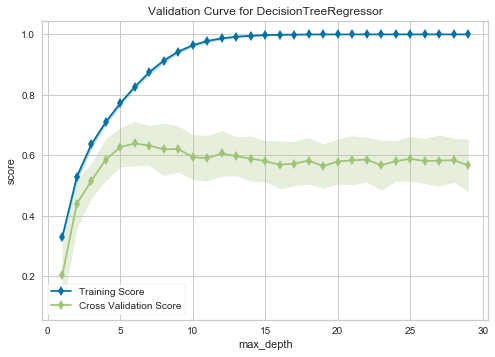

In [28]:
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 30), cv=10, scoring="r2"
)

# Fit and poof the visualizer
viz.fit(X, y)
viz.poof()

It looks like at max_depth=7, validation scores are the highest. Increasing the max_depth can lead to overfitting because the model will see more and more of the training data. 

In [29]:
tree2 = DecisionTreeRegressor(max_depth=7)
tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [30]:
#making predictions
y_pred2 = tree2.predict(X_test)
print(y_pred2[0:5])

[0.55 0.37 0.41 0.42 0.46]


In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 0.021567118700252734
Mean Squared Error: 0.0008251278179149775
Root Mean Squared Error: 0.02872503817081846


MSE is slightly better when using tree2. 

## Random Forest ##

In [32]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(y_pred[0:5])

/Users/mtm101/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/mtm101/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[0.50 0.40 0.42 0.45 0.45]


In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.01580451409020456
Mean Squared Error: 0.0004300283192821369
Root Mean Squared Error: 0.020737124180612337


**Data Dictionary**
- geoid: County FIPS code
- pop: County Population from DataCommons
- housing: Total number of housing units
- kfr_pooled: Mean pctile rank in the national distribution of household income in 2014‐2015 
- P_1 Bankruptcies per 1000 adults in 2008
- P_2 Bankruptcies per 1000 adults in 2009
- P_3 Bankruptcies per 1000 adults in 2010
- P_4 Bankruptcies per 1000 adults in 2011
- P_5 Bankruptcies per 1000 adults in 2012
- P_6 Bankruptcies per 1000 adults in 2013
- P_7 Bankruptcies per 1000 adults in 2014
- P_8 Bankruptcies per 1000 adults in 2015
- P_9 Bankruptcies per 1000 adults in 2016
- P_10 % of Individuals Earning < 138% of the FPL without Insurance in 2013
- P_11 % of Individuals Earning 138%‐400% of the FPL without Insurance in 2013
- P_12 Total Violent and Property Crimes Rate
- P_13 Total Violent Crimes Rate: Murder Rate
- P_14 Total Violent Crimes Rate: Rape Rate
- P_15 Total Violent Crimes Rate: Robbery Rate
- P_16 Total Violent Crimes Rate: Aggravated Assault Rate
- P_17 Total Property Crimes Rate
- P_18 Total Property Crimes Rate: Burglary Rate
- P_19 Total Property Crimes Rate: Larceny Rate
- P_20 Total Property Crimes Rate: Motor Vehicle Theft Rate
- P_21 Total Violent and Property Crime Arrests Rate
- P_22 Total Violent and Property Crime Arrests Rate: Violent Crime Arrests Rate
- P_23 Total Violent and Property Crime Arrests Rate: Property Crime Arrests Rate
- P_24 Mean Household Income 2000
- P_25 Average Commute Time of Working Adults in 2000
- P_26 Fraction of Residents w/ a College Degree or More in 2000
- P_27 Fraction of Residents w/ a College Degree or More in 2006‐2010 ACS
- P_28 Share of Population Born Outside the U.S. in 2006‐2010 ACS
- P_29 Median Household Income in 2016
- P_30 Median Household Income in 1990
- P_31 Share Below Poverty Line 2006‐2010 ACS
- P_32 Share Below Poverty Line 2000
- P_33 Share Below Poverty Line 1990
- P_34 Share black 2010
- P_35 Share hisp 2010
- P_36 Share asian 2010
- P_37 Share black 2000
- P_38 Share white 2000
- P_39 Share hisp 2000
- P_40 Share asian 2000
- P_41 Average School District Level Standardized Test Scores in 3rd Grade in 2013
- P_42 Average Rent for Two‐Bedroom Apartment in 2015
- P_43 Share of Single‐Headed Households with Children 2006‐2010 ACS
- P_44 Share of Single‐Headed Households with Children 1990
- P_45 Share of Single‐Headed Households with Children 2000
- P_46 Share of Working Adults w/ Commute Time of 15 Minutes Or Less in 2006‐2010 ACS
- P_47 Employment Rate 2000
- P_48 Census Form Rate Return Rate 2010
- P_49 Log wage growth for HS Grad., 2005‐2014
- P_50 Share of People who are not white 2010
- P_51 Population Density (per square mile) in 2010
- P_52 Population Density (per square mile) in 2000
- P_53 Average Annual Job Growth Rate 2004‐2013
- P_54 Job Density (in square miles) in 2013
- P_55 Physically Unhealthy Days per Month (Persons 18 Years and Over)
- P_56 Mentally Unhealthy Days per Month (Persons 18 Years and Over)
- P_57 Percent of Adults That Report Fair or Poor Health (Persons 18 Years and Over)
- P_58 Percent of Low Birthweight Births (<2.5kg)
- P_59 Primary Care Physicians (PCP) Rate per 100,000 Population
- P_60 Mental Health Providers (MHP) Rate per 100,000 Population
- P_61 Dentists Rate per 100,000 Population
- P_62 Health Care Costs Price‐adjusted Medicare Reimbursements
- P_63 Percent of Persons Without Insurance (Population Under 19 Years, 2013 est.)
- P_64 Percent of Persons Without Insurance (Population 18 to 64 Years, 2013 est.)
- P_65 Percent of Persons Without Insurance (Population Under 65 Years, 2013 est.)
- P_66 Premature Age‐adjusted Mortality Rate per 100,000 Population
- P_67 Drug Poisoning Mortality Rate per 100,000 Population
- P_68 Percent Diabetics (Adults)
- P_69 Percent of Diabetic Medicare Enrollees Receiving Hba1c Test
- P_70 Diabetic Medicare Enrollees (Out of Total Medicare Enrolles)
- P_71 Teen Births Rate per 100,000 Population (Females 15 to 19 Years)
- P_72 Chlamydia Cases Rate per 100,000 Population
- P_73 HIV Prevalence Rate per 100,000 Population
- P_74 Percent Current Smokers (Persons 18 Years and Over)
- P_75 Percent Drinking Adults (Persons 18 Years and Over)
- P_76 Percent of Persons with Limited Access to Healthy Foods
- P_77 Percent of Persons with Access to Exercise Opportunities
- P_78 Percent Obese Persons (20 Years and Over)
- P_79 Percent Percent Physically Inactive Persons (20 Years and Over)
- P_80 Percent of Children Eligible for Free Lunch (Persons < 18 Years)
- P_81 Food Environment Index
- P_82 % Total: Evangelical Protestant
- P_83 % Total: Mainline Protestant
- P_84 % Total: Historically Black Protestant
- P_85 % Total: Roman Catholic
- P_86 % Total: Jewish Congregations
- P_87 % Total: Latter‐day Saint (Mormon)
- P_88 % Total: Islamic
- P_89 % Total: Hindu
- P_90 % Total: Buddhist
- P_91 % Total: Orthodox Christian
- P_92 % Total: Jehovah's Witnesses
- P_93 % Total: Other
- P_94 % Total: Evangelical Protestant Member Count
- P_95 % Total: Mainline Protestant Member Count
- P_96 % Total: Historically Black Protestant Member Count
- P_97 % Total: Roman Catholic Member Count
- P_98 % Total: Jewish Member Count
- P_99 % Total: Latter‐day Saint (Mormon) Member Count
- P_100 % Total: Islamic Member Count
- P_101 % Total: Hindu Member Count
- P_102 % Total: Buddhist Member Count
- P_103 % Total: Orthodox Christian Member Count
- P_104 % Total: Jehovah's Witnesses Member Count
- P_105 % Total: Other Member Count
- P_106 % Total Evangelical Protestant: Advent Christian Church
- P_107 % Total Evangelical Protestant: Adventists ‐ Other
- P_108 % Total Evangelical Protestant: Church of God General Conference
- P_109 % Total Evangelical Protestant: Seventh Day Adventists
- P_110 % Total Evangelical Protestant: Seventh Day Church of God
- P_111 % Total Evangelical Protestant: American Baptist Association
- P_112 % Total Evangelical Protestant: Baptist General Conference
- P_113 % Total Evangelical Protestant: Baptist ‐ Other
- P_114 % Total Evangelical Protestant: Baptist Bible Fellowship
- P_115 % Total Evangelical Protestant: Baptist Missionary Association of America
- P_116 % Total Evangelical Protestant: Cooperative Baptist Fellowship
- P_117 % Total Evangelical Protestant: Independent Baptist Churches
- P_118 % Total Evangelical Protestant: Conservative Baptist Association
- P_119 % Total Evangelical Protestant: Free Will Baptists
- P_120 % Total Evangelical Protestant: General Assoc. of Regular Baptists
- P_121 % Total Evangelical Protestant: Assoc. of General Baptists